In [1]:
from splitwise_sync.config import RAW_DIR, INTERIM_DIR, PROCESSED_DIR

In [2]:
import pandas as pd
import geopandas as gpd

1. Obtener ubicaciones - cuando los pagos fueron realizados por Diego
2. Obtener correos electrónicos de transacciones, a partir del 2025-01-01
3. Obtener transacciones de Splitwise, incluir las transacciones eliminadas, pero mantener solo las más recientes con el mismo precio y descripción/hash.
   Conservar solo las creadas por Diego.



In [3]:
def clean_datetime_serie(serie: pd.Series, timezone="America/Santiago") -> pd.Series:
    """
    Cleans a datetime column by converting it to a standard format.
    """
    new = pd.to_datetime(
        serie, format="ISO8601", utc=True, errors="coerce"
    ).dt.tz_convert(timezone)
    return new

In [4]:
!ls '/Users/diegocaro/Documents/Projects/splitwise-sync/splitwise_sync/data/raw/locations.jsonl'

ls: /Users/diegocaro/Documents/Projects/splitwise-sync/splitwise_sync/data/raw/locations.jsonl: No such file or directory


<Axes: >

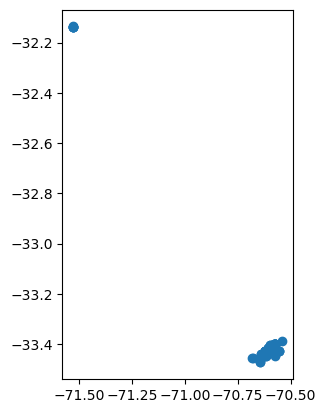

In [5]:
def read_locations(file_name: str) -> gpd.GeoDataFrame:
    assert file_name.endswith(".jsonl"), "File must be a JSON Lines file"
    df = pd.read_json(file_name, lines=True)
    df["date"] = clean_datetime_serie(df["date"])
    df = df.reset_index(drop=False, names=["id"])

    gdf = gpd.GeoDataFrame(
        df,
        geometry=gpd.points_from_xy(df["lon"], df["lat"]),
        crs="EPSG:4326",
    )

    drop_columns = ["lon", "lat", "transaction"]
    drop_columns = [col for col in drop_columns if col in df.columns]
    gdf = gdf.drop(columns=drop_columns)

    gdf = gdf.rename(columns=lambda x: f"location_{x}" if x not in ["geometry"] else x)
    return gdf


locations = read_locations(str(RAW_DIR / "locations.jsonl"))
locations.plot()

In [6]:
locations

,location_id,location_address,location_date,location_name,geometry
0,0,General Flores 20\nProvidencia\nSantiago Metro...,2025-01-20 14:03:57-03:00,General Flores 20\nProvidencia\nSantiago Metro...,POINT (-70.61868 -33.42785)
1,1,Roger de Flor 2737\nLas Condes\nSantiago Metro...,2025-02-19 13:28:41-03:00,Roger de Flor 2737\nLas Condes\nSantiago Metro...,POINT (-70.60144 -33.41722)
2,2,Amapolas 1290\nProvidencia\nSantiago Metropoli...,2025-03-16 13:07:24-03:00,Amapolas 1290\nProvidencia\nSantiago Metropoli...,POINT (-70.59211 -33.4273)
3,3,Orrego Luco 16\nProvidencia\nSantiago Metropol...,2025-04-15 19:01:55-04:00,Orrego Luco 16\nProvidencia\nSantiago Metropol...,POINT (-70.6122 -33.42307)
4,4,Orrego Luco 54\nProvidencia\nSantiago Metropol...,2025-02-16 13:27:23-03:00,Orrego Luco 54\nProvidencia\nSantiago Metropol...,POINT (-70.61264 -33.42286)
...,...,...,...,...,...
245,245,Avenida Apoquindo 2730\nLas Condes\nSantiago M...,2025-03-18 19:13:51-03:00,Avenida Apoquindo 2730\nLas Condes\nSantiago M...,POINT (-70.60133 -33.41731)
246,246,Encomenderos 1\nLas Condes\nSantiago Metropoli...,2025-02-02 16:21:19-03:00,Encomenderos 1\nLas Condes\nSantiago Metropoli...,POINT (-70.60196 -33.41697)
247,247,El Vergel 2932\nProvidencia\nSantiago Metropol...,2025-03-14 19:06:35-03:00,El Vergel 2932\nProvidencia\nSantiago Metropol...,POINT (-70.59138 -33.42971)
248,248,Avenida Apoquindo 2730\nLas Condes\nSantiago M...,2025-02-12 18:49:41-03:00,Avenida Apoquindo 2730\nLas Condes\nSantiago M...,POINT (-70.60121 -33.41741)


In [7]:
from typing import Optional

EXPENSES_CLEANED_COLUMNS = [
    "id",
    "date",
    "category_name",
    "description",
    "cost",
    "details",
    "created_at",
    "updated_at",
    "deleted_at",
    "created_by_name",
    "updated_by_name",
    "deleted_by_name",
]


def is_duplicated_expense(expenses: pd.DataFrame) -> pd.Series:
    # Un expense se considera duplicado si tiene la misma fecha, costo y descripción
    # Marcaremos como duplicados a los que tienen una fecha de deleted_at no nula (que fueron eliminados)
    # cols = ["date", "cost", "description"]
    cols = [
        "date",
        "cost",
    ]  # I changed the description of some expenses when testing, but they are the same in the end...
    duplicated = (
        expenses.groupby(cols)
        .agg(cnt=("id", "count"), ids=("id", list))
        .pipe(lambda df: df[df.cnt > 1])
    )
    duplicated_ids = duplicated["ids"].explode().unique()
    is_duplicated = expenses["id"].isin(duplicated_ids) & ~expenses["deleted_at"].isna()
    return is_duplicated


def read_expenses(
    file_name: str,
    keep_all_columns: Optional[bool] = False,
    keep_duplicated: Optional[bool] = True,
) -> pd.DataFrame:
    assert file_name.endswith(".json"), "File must be a JSON file"

    df = pd.read_json(file_name)
    df["id"] = df["id"].astype("Int64")
    for col in ["date", "created_at", "updated_at", "deleted_at"]:
        df[col] = clean_datetime_serie(df[col])

    for col in ["created_by", "updated_by", "deleted_by"]:
        df[f"{col}_id"] = df[col].str["id"]
        df[f"{col}_name"] = df[col].str["first_name"]

    df["category_id"] = df["category"].str["id"]
    df["category_name"] = df["category"].str["name"]

    if not keep_all_columns:
        df = df[EXPENSES_CLEANED_COLUMNS]

    is_duplicated = is_duplicated_expense(df)
    if keep_duplicated:
        df["is_duplicated"] = is_duplicated
    else:
        df = df[~is_duplicated]

    df = df.rename(columns=lambda x: f"expense_{x}")
    return df


expenses = read_expenses(str(RAW_DIR / "expenses.json"), keep_all_columns=False)
expenses

,expense_id,expense_date,expense_category_name,expense_description,expense_cost,expense_details,expense_created_at,expense_updated_at,expense_deleted_at,expense_created_by_name,expense_updated_by_name,expense_deleted_by_name,expense_is_duplicated
0,3767480899,2025-04-23 19:16:00-04:00,General,SEBASTIAN SANTIAGO CHL,5980.0,una compra por $5.980 con Tarjeta de Crédito *...,2025-04-23 19:20:05-04:00,2025-04-23 19:20:05-04:00,NaT,Diego,None,None,False
1,3767480895,2025-04-23 19:11:00-04:00,General,RESTAURANTE EL HUERTO SANTIAGO CHL,31460.0,una compra por $31.460 con Tarjeta de Crédito ...,2025-04-23 19:20:04-04:00,2025-04-23 19:20:04-04:00,NaT,Diego,None,None,False
2,3767403107,2025-04-23 17:36:00-04:00,General,MERCADOPAGO *QUIPUSAL Las Condes CHL,55000.0,una compra por $55.000 con Tarjeta de Crédito ...,2025-04-23 17:40:05-04:00,2025-04-23 18:04:41-04:00,2025-04-23 18:04:41-04:00,Diego,None,Diego,False
3,3767229458,2025-04-23 15:07:00-04:00,General,SPID MUT - O871 SANTIAGO CHL,1190.0,una compra por $1.190 con Tarjeta de Crédito *...,2025-04-23 15:10:04-04:00,2025-04-23 15:25:37-04:00,2025-04-23 15:25:37-04:00,Diego,None,Diego,False
4,3767229442,2025-04-23 15:05:00-04:00,General,HAULMER*CEVICHERIA AL SANTIAGO CHL,8500.0,una compra por $8.500 con Tarjeta de Crédito *...,2025-04-23 15:10:04-04:00,2025-04-23 15:25:30-04:00,2025-04-23 15:25:30-04:00,Diego,None,Diego,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3221560784,2024-06-29 21:13:00-04:00,Groceries,Paumar,4490.0,None,2024-07-04 21:14:09-04:00,2024-07-04 22:40:48-04:00,NaT,Daniela,Daniela,None,False
996,3221560460,2024-06-29 21:13:00-04:00,Groceries,Verduras,1680.0,None,2024-07-04 21:13:35-04:00,2024-07-04 21:13:35-04:00,NaT,Daniela,None,None,False
997,3210244911,2024-06-29 18:04:33-04:00,Utilities - Other,Dinero en efectivo,30000.0,None,2024-06-29 18:05:05-04:00,2024-06-29 18:05:05-04:00,NaT,Diego,None,None,False
998,3209983335,2024-06-29 15:03:07-04:00,Dining out,Rienda suelta bar,25980.0,None,2024-06-29 15:03:28-04:00,2024-06-29 15:03:52-04:00,NaT,Diego,Diego,None,False


In [8]:
expenses[expenses.expense_is_duplicated].shape[0]

38

In [9]:
expenses.groupby(["expense_date", "expense_cost"]).expense_id.count().pipe(
    lambda s: s[s > 1]
)

expense_date               expense_cost
2024-09-08 19:07:00-03:00  27500.0          2
2025-04-15 19:10:00-04:00  52470.0          3
2025-04-18 20:14:00-04:00  11126.0          3
2025-04-19 14:33:00-04:00  1190.0          12
2025-04-21 17:15:00-04:00  16610.0          7
2025-04-22 19:00:00-04:00  55935.0          5
2025-04-22 19:59:00-04:00  419.0           10
Name: expense_id, dtype: Int64

In [10]:
expenses = expenses[~expenses.expense_is_duplicated]

In [11]:
from functools import reduce
from typing import Callable


def apply_transforms(
    df: pd.DataFrame, transforms: Callable[[pd.DataFrame], pd.DataFrame]
) -> pd.DataFrame:
    df = reduce(
        lambda df, transform: transform(df),
        transforms,
        df,
    )
    return df

In [12]:
def expand_dict_column(column_name: str) -> Callable[[pd.DataFrame], pd.DataFrame]:
    def inner(df: pd.DataFrame) -> pd.DataFrame:
        fill_na_values = lambda x: x if isinstance(x, dict) else {}
        df[column_name] = df[column_name].apply(fill_na_values)
        frame = (
            df[column_name]
            .apply(pd.Series)
            .rename(columns=lambda x: f"{column_name}_{x}")
        )
        return frame.join(df.drop(column_name, axis=1))

    return inner


TRANSACTION_CLEANED_COLUMNS = [
    "transaction_cost",
    "transaction_currency_code",
    "transaction_date",
    "transaction_description",
    "transaction_card_number",
    "transaction_hash",
]


def read_emails(
    filename: str, keep_all_columns: Optional[bool] = False, keep_errored: bool = False
) -> pd.DataFrame:
    assert filename.endswith(".json"), "File must be a JSON file"
    df = pd.read_json(filename)
    transforms = [expand_dict_column("email"), expand_dict_column("transaction")]
    frame = apply_transforms(df, transforms)
    for col in ["transaction_date", "email_date"]:
        frame[col] = clean_datetime_serie(frame[col])

    if not keep_errored:
        frame = frame[frame["error"].isna()]

    if not keep_all_columns:
        frame = frame[TRANSACTION_CLEANED_COLUMNS]
    return frame


transactions = read_emails(str(RAW_DIR / "emails.json"))
transactions

,transaction_cost,transaction_currency_code,transaction_date,transaction_description,transaction_card_number,transaction_hash
0,5000.0,CLP,2025-01-02 19:25:00-03:00,MERPAGO*V CARUSI V CAR PROVIDENCIA CHL,7766,9393cc2ff8957cc6a5478fd2590654317b6544d4386fb4...
1,17450.0,CLP,2025-01-02 20:23:00-03:00,DOMINOS PIZZA TOBALABA SANTIAGO CHL,7766,db94e38b2fa10f6cec5953bb6ce458e406d9702461a93e...
5,23800.0,CLP,2025-01-03 14:13:00-03:00,RIENDA MUT SPA SANTIAGO CHL,7766,3288705b6a246d2677e76a8fd96ed62ad210cdcae23585...
6,4500.0,CLP,2025-01-03 14:17:00-03:00,TIERRA CERVECERA SANTIAGO CHL,7766,01d800039fa64c4f658fb34222f2d7ca0db7058d38fdf8...
7,7280.0,CLP,2025-01-03 15:01:00-03:00,SumUp * SOCIEDAD DE IN Quilicura CHL,7766,7198cf667295e8346e924f3f9e5817fe8c5862f8bc9ee5...
...,...,...,...,...,...,...
394,1190.0,CLP,2025-04-23 15:07:00-04:00,SPID MUT - O871 SANTIAGO CHL,7766,0be10f8e4a6e72ddd41bb5c0c7194c606293acb273ec92...
395,6600.0,CLP,2025-04-23 15:52:00-04:00,CAFETERIA THE ELEPHANT SANTIAGO CHL,7766,23885bc518c101da0f60c629176cf31e7ec10ac0a37028...
396,55000.0,CLP,2025-04-23 17:36:00-04:00,MERCADOPAGO *QUIPUSAL Las Condes CHL,7766,11f22f8d361dedd67f5a98470342ad0f23d94d07fac725...
397,31460.0,CLP,2025-04-23 19:11:00-04:00,RESTAURANTE EL HUERTO SANTIAGO CHL,7766,21313bd0e6b5966f6fcf8a27a9691f5f0bdf7a986562a8...


In [13]:
is_cajero = transactions["transaction_description"].str.contains(
    "con cargo a Cuenta ****4503", regex=False
)
transactions[is_cajero]

,transaction_cost,transaction_currency_code,transaction_date,transaction_description,transaction_card_number,transaction_hash
34,20000.0,CLP,2025-01-12 12:38:00-03:00,Cajero por $20.000 con cargo a Cuenta ****4503,4503,5d262d3f4260d10b29ab1f912dea3e251d243fafc67c7c...
77,200000.0,CLP,2025-01-25 13:33:00-03:00,Cajero por $200.000 con cargo a Cuenta ****4503,4503,b72d9ce7edc7b6ee92bf97658c1559d009f6af542b29b2...
147,20000.0,CLP,2025-02-16 12:28:00-03:00,Cajero por $20.000 con cargo a Cuenta ****4503,4503,e9b2de8e9f22f4e135a605266274f87047fd159bfddfea...
165,20000.0,CLP,2025-02-22 17:17:00-03:00,Cajero por $20.000 con cargo a Cuenta ****4503,4503,9fcd01e588fdc17559b7426994d21779d6a8c0bd417ba5...
287,30000.0,CLP,2025-03-22 14:07:00-03:00,Cajero por $30.000 con cargo a Cuenta ****4503,4503,9c053cadb0b0e85bef3f33f2767bae311c72d9bcb8ee85...


In [14]:
transactions = transactions[~is_cajero]

In [15]:
transactions["transaction_description"].unique()

array(['MERPAGO*V CARUSI V CAR PROVIDENCIA   CHL',
       'DOMINOS PIZZA TOBALABA SANTIAGO      CHL',
       'RIENDA MUT SPA         SANTIAGO      CHL',
       'TIERRA CERVECERA       SANTIAGO      CHL',
       'SumUp * SOCIEDAD DE IN Quilicura     CHL',
       'APPLE.COM/BILL         866-712-7753  USA',
       'CINE HOYTS PLAZA EGANA SANTIAGO      CHL',
       'AHUM L272 LOS LEONES 1 SANTIAGO      CHL',
       'MERPAGO*COMERCIAL MKM  SANTIAGO      CHL',
       'SPACIO 1               SANTIAGO      CHL',
       'TRAVEL TICKETMASTER    SANTIAGO      CHL',
       'SALCOBRAND  PROVIDENCI SANTIAGO      CHL',
       'TUS MASCOTAS           SANTIAGO      CHL',
       'PUNTO MASCOTAS         SANTIAGO      CHL',
       'MP     *MERCADO PAGO   SANTIAGO      CHL',
       'CLUB ENTRE PATITAS     SANTIAGO      CHL',
       'SPID MUT - O871        SANTIAGO      CHL',
       'SB 727                 SANTIAGO      CHL',
       'MERPAGO*LA FIAMBRERIA  SANTIAGO      CHL',
       'EKONO TOBALABA         

In [ ]:
transactions.to_pickle(INTERIM_DIR / "transactions.pkl")
locations.to_file(INTERIM_DIR / "locations.geojson", driver="GeoJSON")
expenses.to_pickle(INTERIM_DIR / "expenses.pkl")

# Joined datasets with location and expenses

Cómo asociar transacciones con gastos
1. Muy fácil: usar los campos hash. Asumir que las transacciones eliminadas significan "gasto personal"
2. Asociar transacciones por día y con montos similares. Podemos asumir que cualquier transacción que no esté en Splitwise puede ser personal.

Estudiar:
1. ¿Existe alguna relación entre la descripción y el comerciante de la transacción? Es decir, ¿podemos crear una mejor descripción a partir del comerciante?
2. ¿Cuál es la relación entre las ubicaciones y los gastos? Cuánto aporta en predecir que es un gasto personal/compartido?

In [17]:
def match_transactions(
    expenses_df: pd.DataFrame,
    transactions_df: pd.DataFrame,
    date_threshold: pd.Timedelta = pd.Timedelta("12h"),
    amount_threshold: float = 0.001,
) -> pd.DataFrame:
    # This is very slow, but it works
    # Need to rework if you want to use all your emails and expenses

    assert expenses_df["expense_id"].is_unique, "Expenses ids are not unique"
    assert transactions_df[
        "transaction_hash"
    ].is_unique, "Transactions hashes are not unique"

    expenses = expenses_df.copy()
    transactions = transactions_df.copy()

    # Create empty lists to store match results
    matches = []

    # For each expense, find potential matching transactions
    for _, expense in expenses.iterrows():
        # Filter transactions by date range
        date_min = expense["expense_date"] - date_threshold
        date_max = expense["expense_date"] + date_threshold
        date_filtered = transactions[
            (transactions["transaction_date"] >= date_min)
            & (transactions["transaction_date"] <= date_max)
        ].copy()

        if len(date_filtered) == 0:
            continue

        # Filter by amount similarity
        amount = expense["expense_cost"]
        date_filtered["amount_diff"] = (
            abs(date_filtered["transaction_cost"] - amount) / amount
        )
        potential_matches = date_filtered[
            date_filtered["amount_diff"] <= amount_threshold
        ]
        if len(potential_matches) > 0:

            # Get the best match (smallest amount difference)
            k = 1
            top_matches = potential_matches.sort_values("amount_diff").iloc[:k]
            for _, best_match in top_matches.iterrows():
                matches.append(
                    {
                        "expense_id": expense["expense_id"],
                        "transaction_hash": best_match["transaction_hash"],
                        "amount_diff": best_match["amount_diff"],
                        "cost_diff": abs(
                            expense["expense_cost"] - best_match["transaction_cost"]
                        ),
                        "expense_time_diff": abs(
                            expense["expense_date"] - best_match["transaction_date"]
                        ),
                    }
                )
    matches = pd.DataFrame(matches)
    assert matches.expense_id.is_unique, "Expense ids are not unique in matches"
    # assert matches.transaction_hash.is_unique, "Transaction hashes are not unique in matches"
    return matches


for threshold in [0.1, 0.01, 0.001]:
    print(f"Threshold: {threshold}")
    matched_transactions = match_transactions(
        expenses, transactions, amount_threshold=threshold
    )
    print(
        f"number of rows: {len(matched_transactions)}, max difference $ {matched_transactions['cost_diff'].max()} CLP"
    )

Threshold: 0.1
number of rows: 196, max difference $ 7181.0 CLP
Threshold: 0.01
number of rows: 178, max difference $ 609.0 CLP
Threshold: 0.001
number of rows: 171, max difference $ 0.0 CLP


In [18]:
matched_transactions = match_transactions(
    expenses, transactions, amount_threshold=0.001
)
matched_transactions = (
    matched_transactions.merge(
        expenses, left_on="expense_id", right_on="expense_id", how="left"
    )
    .merge(
        transactions,
        left_on="transaction_hash",
        right_on="transaction_hash",
        how="right",
    )
    .pipe(lambda df: df.assign(expense_id=df["expense_id"].astype("Int64")))
)
matched_transactions

,expense_id,transaction_hash,amount_diff,cost_diff,expense_time_diff,expense_date,expense_category_name,expense_description,expense_cost,expense_details,...,expense_deleted_at,expense_created_by_name,expense_updated_by_name,expense_deleted_by_name,expense_is_duplicated,transaction_cost,transaction_currency_code,transaction_date,transaction_description,transaction_card_number
0,<NA>,9393cc2ff8957cc6a5478fd2590654317b6544d4386fb4...,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,...,NaT,NaN,NaN,NaN,<NA>,5000.0,CLP,2025-01-02 19:25:00-03:00,MERPAGO*V CARUSI V CAR PROVIDENCIA CHL,7766
1,<NA>,db94e38b2fa10f6cec5953bb6ce458e406d9702461a93e...,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,...,NaT,NaN,NaN,NaN,<NA>,17450.0,CLP,2025-01-02 20:23:00-03:00,DOMINOS PIZZA TOBALABA SANTIAGO CHL,7766
2,3574032303,3288705b6a246d2677e76a8fd96ed62ad210cdcae23585...,0.0,0.0,0 days 00:52:05,2025-01-03 15:05:05-03:00,Dining out,Rienda Suelta Bar,23800.0,None,...,NaT,Diego,None,None,False,23800.0,CLP,2025-01-03 14:13:00-03:00,RIENDA MUT SPA SANTIAGO CHL,7766
3,<NA>,01d800039fa64c4f658fb34222f2d7ca0db7058d38fdf8...,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,...,NaT,NaN,NaN,NaN,<NA>,4500.0,CLP,2025-01-03 14:17:00-03:00,TIERRA CERVECERA SANTIAGO CHL,7766
4,3574033377,7198cf667295e8346e924f3f9e5817fe8c5862f8bc9ee5...,0.0,0.0,0 days 00:04:38,2025-01-03 15:05:38-03:00,Dining out,Café,7280.0,None,...,NaT,Diego,None,None,False,7280.0,CLP,2025-01-03 15:01:00-03:00,SumUp * SOCIEDAD DE IN Quilicura CHL,7766
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
372,3767229458,0be10f8e4a6e72ddd41bb5c0c7194c606293acb273ec92...,0.0,0.0,0 days 00:00:00,2025-04-23 15:07:00-04:00,General,SPID MUT - O871 SANTIAGO CHL,1190.0,una compra por $1.190 con Tarjeta de Crédito *...,...,2025-04-23 15:25:37-04:00,Diego,None,Diego,False,1190.0,CLP,2025-04-23 15:07:00-04:00,SPID MUT - O871 SANTIAGO CHL,7766
373,<NA>,23885bc518c101da0f60c629176cf31e7ec10ac0a37028...,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,...,NaT,NaN,NaN,NaN,<NA>,6600.0,CLP,2025-04-23 15:52:00-04:00,CAFETERIA THE ELEPHANT SANTIAGO CHL,7766
374,3767403107,11f22f8d361dedd67f5a98470342ad0f23d94d07fac725...,0.0,0.0,0 days 00:00:00,2025-04-23 17:36:00-04:00,General,MERCADOPAGO *QUIPUSAL Las Condes CHL,55000.0,una compra por $55.000 con Tarjeta de Crédito ...,...,2025-04-23 18:04:41-04:00,Diego,None,Diego,False,55000.0,CLP,2025-04-23 17:36:00-04:00,MERCADOPAGO *QUIPUSAL Las Condes CHL,7766
375,3767480895,21313bd0e6b5966f6fcf8a27a9691f5f0bdf7a986562a8...,0.0,0.0,0 days 00:00:00,2025-04-23 19:11:00-04:00,General,RESTAURANTE EL HUERTO SANTIAGO CHL,31460.0,una compra por $31.460 con Tarjeta de Crédito ...,...,NaT,Diego,None,None,False,31460.0,CLP,2025-04-23 19:11:00-04:00,RESTAURANTE EL HUERTO SANTIAGO CHL,7766


In [19]:
matched_transactions[
    matched_transactions.transaction_hash
    == "b03b6b7e3e2b8a70535488a40b6d30ec4aebd828a7a2161e4fb2de843ca2fc4e"
]

,expense_id,transaction_hash,amount_diff,cost_diff,expense_time_diff,expense_date,expense_category_name,expense_description,expense_cost,expense_details,...,expense_deleted_at,expense_created_by_name,expense_updated_by_name,expense_deleted_by_name,expense_is_duplicated,transaction_cost,transaction_currency_code,transaction_date,transaction_description,transaction_card_number
366,3763887283,b03b6b7e3e2b8a70535488a40b6d30ec4aebd828a7a216...,0.0,0.0,0 days,2025-04-21 17:15:00-04:00,Dining out,SAKUMU SANTIAGO CHL,16610.0,una compra por $16.610 con Tarjeta de Crédito ...,...,NaT,Diego,Diego,None,False,16610.0,CLP,2025-04-21 17:15:00-04:00,SAKUMU SANTIAGO CHL,7766


In [20]:
def match_locations(
    transactions_df: pd.DataFrame,
    locations_df: gpd.GeoDataFrame,
    date_threshold: pd.Timedelta = pd.Timedelta("1m"),
) -> pd.DataFrame:
    # This is very slow, but it works
    # Need to rework if you want to use all your emails and expenses

    assert transactions_df[
        "transaction_hash"
    ].is_unique, "Transactions hashes are not unique"

    transactions = transactions_df.copy()
    locations = locations_df.copy()

    # Create empty lists to store match results
    matches = []

    # For each transaction, find potential matching locations
    for _, transaction in transactions.iterrows():
        # Filter locations by date range
        date_min = transaction["transaction_date"] - pd.Timedelta(date_threshold)
        date_max = transaction["transaction_date"] + pd.Timedelta(date_threshold)
        date_filtered = locations[
            (locations["location_date"] >= date_min)
            & (locations["location_date"] <= date_max)
        ].copy()
        date_filtered["time_diff"] = abs(
            date_filtered["location_date"] - transaction["transaction_date"]
        )

        if len(date_filtered) == 0:
            continue

        potential_matches = date_filtered
        if len(potential_matches) > 0:
            k = 1
            top_matches = potential_matches.sort_values("time_diff").iloc[:k]
            for _, best_match in top_matches.iterrows():
                matches.append(
                    {
                        "transaction_hash": transaction["transaction_hash"],
                        "location_id": best_match["location_id"],
                        "location_time_diff": best_match["time_diff"],
                    }
                )
    matches = pd.DataFrame(matches)
    assert (
        matches.transaction_hash.is_unique
    ), "Transaction hashes are not unique in matches"
    # assert matches.location_id.is_unique, "Location ids are not unique in matches"
    return matches


matched_locs = match_locations(transactions, locations, pd.Timedelta("5m"))
matched_transactions_locs = matched_locs.merge(
    locations, left_on="location_id", right_on="location_id", how="left"
).merge(
    matched_transactions,
    left_on="transaction_hash",
    right_on="transaction_hash",
    how="right",
)
matched_transactions_locs

,transaction_hash,location_id,location_time_diff,location_address,location_date,location_name,geometry,expense_id,amount_diff,cost_diff,...,expense_deleted_at,expense_created_by_name,expense_updated_by_name,expense_deleted_by_name,expense_is_duplicated,transaction_cost,transaction_currency_code,transaction_date,transaction_description,transaction_card_number
0,9393cc2ff8957cc6a5478fd2590654317b6544d4386fb4...,NaN,NaT,NaN,NaT,NaN,None,<NA>,NaN,NaN,...,NaT,NaN,NaN,NaN,<NA>,5000.0,CLP,2025-01-02 19:25:00-03:00,MERPAGO*V CARUSI V CAR PROVIDENCIA CHL,7766
1,db94e38b2fa10f6cec5953bb6ce458e406d9702461a93e...,NaN,NaT,NaN,NaT,NaN,None,<NA>,NaN,NaN,...,NaT,NaN,NaN,NaN,<NA>,17450.0,CLP,2025-01-02 20:23:00-03:00,DOMINOS PIZZA TOBALABA SANTIAGO CHL,7766
2,3288705b6a246d2677e76a8fd96ed62ad210cdcae23585...,NaN,NaT,NaN,NaT,NaN,None,3574032303,0.0,0.0,...,NaT,Diego,None,None,False,23800.0,CLP,2025-01-03 14:13:00-03:00,RIENDA MUT SPA SANTIAGO CHL,7766
3,01d800039fa64c4f658fb34222f2d7ca0db7058d38fdf8...,NaN,NaT,NaN,NaT,NaN,None,<NA>,NaN,NaN,...,NaT,NaN,NaN,NaN,<NA>,4500.0,CLP,2025-01-03 14:17:00-03:00,TIERRA CERVECERA SANTIAGO CHL,7766
4,7198cf667295e8346e924f3f9e5817fe8c5862f8bc9ee5...,NaN,NaT,NaN,NaT,NaN,None,3574033377,0.0,0.0,...,NaT,Diego,None,None,False,7280.0,CLP,2025-01-03 15:01:00-03:00,SumUp * SOCIEDAD DE IN Quilicura CHL,7766
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
372,0be10f8e4a6e72ddd41bb5c0c7194c606293acb273ec92...,NaN,NaT,NaN,NaT,NaN,None,3767229458,0.0,0.0,...,2025-04-23 15:25:37-04:00,Diego,None,Diego,False,1190.0,CLP,2025-04-23 15:07:00-04:00,SPID MUT - O871 SANTIAGO CHL,7766
373,23885bc518c101da0f60c629176cf31e7ec10ac0a37028...,NaN,NaT,NaN,NaT,NaN,None,<NA>,NaN,NaN,...,NaT,NaN,NaN,NaN,<NA>,6600.0,CLP,2025-04-23 15:52:00-04:00,CAFETERIA THE ELEPHANT SANTIAGO CHL,7766
374,11f22f8d361dedd67f5a98470342ad0f23d94d07fac725...,NaN,NaT,NaN,NaT,NaN,None,3767403107,0.0,0.0,...,2025-04-23 18:04:41-04:00,Diego,None,Diego,False,55000.0,CLP,2025-04-23 17:36:00-04:00,MERCADOPAGO *QUIPUSAL Las Condes CHL,7766
375,21313bd0e6b5966f6fcf8a27a9691f5f0bdf7a986562a8...,NaN,NaT,NaN,NaT,NaN,None,3767480895,0.0,0.0,...,NaT,Diego,None,None,False,31460.0,CLP,2025-04-23 19:11:00-04:00,RESTAURANTE EL HUERTO SANTIAGO CHL,7766


In [21]:
assert (
    transactions.shape[0] == matched_transactions_locs.shape[0]
), "Number of transactions do not match"

# Label classes is_shared

In [22]:
matched_transactions_locs["expense_deleted_by_name"].value_counts(dropna=False)

expense_deleted_by_name
NaN      206
None     166
Diego      5
Name: count, dtype: int64

In [23]:
matched_transactions_locs["is_shared_feedback"] = (
    matched_transactions_locs["expense_deleted_by_name"] == "Diego"
)  # manual feedback in the app - when the user deletes the expense
matched_transactions_locs["is_shared"] = (
    matched_transactions_locs["expense_id"].notnull()
    | matched_transactions_locs["is_shared_feedback"]
)
matched_transactions_locs[matched_transactions_locs["is_shared_feedback"]]

,transaction_hash,location_id,location_time_diff,location_address,location_date,location_name,geometry,expense_id,amount_diff,cost_diff,...,expense_updated_by_name,expense_deleted_by_name,expense_is_duplicated,transaction_cost,transaction_currency_code,transaction_date,transaction_description,transaction_card_number,is_shared_feedback,is_shared
360,e8fd5574e68fc2d4c010182e70c72e92f4197d89fd1cef...,NaN,NaT,NaN,NaT,NaN,None,3761863369,0.0,0.0,...,None,Diego,False,8.8,US,2025-04-20 15:36:00-04:00,APPLE.COM/BILL 866-712-7753 USA,7766,True,True
365,b8e9d8f67ca046cd4ceb798504bef821de8ed2576e8eb0...,NaN,NaT,NaN,NaT,NaN,None,3763662280,0.0,0.0,...,None,Diego,False,1190.0,CLP,2025-04-21 14:41:00-04:00,SPID MUT - O871 SANTIAGO CHL,7766,True,True
371,ac1f9aa893a8d3ad62f4189948bfff231cc9166adeefa6...,NaN,NaT,NaN,NaT,NaN,None,3767229442,0.0,0.0,...,None,Diego,False,8500.0,CLP,2025-04-23 15:05:00-04:00,HAULMER*CEVICHERIA AL SANTIAGO CHL,7766,True,True
372,0be10f8e4a6e72ddd41bb5c0c7194c606293acb273ec92...,NaN,NaT,NaN,NaT,NaN,None,3767229458,0.0,0.0,...,None,Diego,False,1190.0,CLP,2025-04-23 15:07:00-04:00,SPID MUT - O871 SANTIAGO CHL,7766,True,True
374,11f22f8d361dedd67f5a98470342ad0f23d94d07fac725...,NaN,NaT,NaN,NaT,NaN,None,3767403107,0.0,0.0,...,None,Diego,False,55000.0,CLP,2025-04-23 17:36:00-04:00,MERCADOPAGO *QUIPUSAL Las Condes CHL,7766,True,True


In [24]:
matched_transactions_locs.to_pickle(
    PROCESSED_DIR / "matched_transactions_locs.pkl"
)  # Save the matched transactions with locations